# ShapeClassifierNet
**My first neural network!** We're going to make a **basic neural network that takes in a drawing of a basic shape and classifies it**. This is the perfect first project for me, because unlike MNIST handwritten digit classification, where the work is basically done for me and there's not much I can glean from it, **ShapeClassifierNet** offers a rich learning experience for me. As a relatively unique idea, it's straightforward enough for me to be able to navigate alone, yet complex enough to provide genuine learning experiences.

Note: this notebook is a much more cleaned up version of my original notebook. In the original notebook, I did tons of extra data exploration and just trying tons of things before I settled on my final ideas. I obviously didn't include it here because there would be no way to organize all of it. It would only clutter things, when what really matters are my final decisions. So **this notebook very accurately documents my journey, just without the all trial and error.**

The only obstacle with this project was that I had absolutely no idea on how I was going to be able to gather this type of data. Luckily, I had an amazing idea during the Google workshop when I was at ShellHacks '23. While there, I was reminded of **Google QuickDraw**, which I had used years ago. QuickDraw provides free access to a large amount of the type of basic drawings I was looking for. We can pull out the drawings of just the basic shapes from this data, and train a model on identifying them. **I found 5 shapes (classes), and these are: triangle, square, circle, star, and line.**

Let's get started!

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from math import radians, sqrt, sin, cos
from collections import defaultdict
from sklearn.utils import shuffle
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from copy import deepcopy
import tensorflow as tf
from time import time
import numpy as np
import datetime
import requests
import random
import json
import os

2023-10-03 13:39:33.290557: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-03 13:39:33.313714: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 13:39:33.417469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 13:39:33.418543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 13:39:34.065290: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Directory for downloaded QuickDraw data
DATASET_PATH = 'quickdraw_dataset/'

# Random state value for reproducibility
RAND_STATE_VAL = 169
random.seed(RAND_STATE_VAL)

# Define classes of shapes
classes = ['triangle', 'square', 'circle', 'star', 'line']

# Data Loading
As described above, we're going to be using data from QuickDraw, Google's pretty cool AI. We're able to download the data directly from the Google API by using a GET request. The data consists of many thousands of drawings drawn by users, and each one includes a tag indicating whether's Google AI was able to recognize the drawing. Looking at the unrecognized drawings, most of them don't match the class, which makes sense why Google's AI wasn't able to classify them, so very simply we're only going to use only the recognized drawings. As the data is requested from the web, we're going to store it in a dictionary corresponding to each shape/class. We need to keep the data separate by class for now while we preprocess and split, to maintain class balance, then we can combine them.

In [3]:
url = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/{}.ndjson'
dataset = defaultdict(list)

# Specific drawings to pull for demo later
shape_drawings = {
    'triangle': '5422932853522432',
    'square': '5842683031453696',
    'circle': '6387315482034176',
    'star': '6621911364665344',
    'line': '5804143316828160'
}

key_drawings = []

# Creates dataset directory if it doesn't exist
if os.path.exists(DATASET_PATH) is False:
    print('dataset directory doesn\'t exist, creating it...')
    os.mkdir(DATASET_PATH)

# Iterates through shapes and downloads each one's data
for shape in classes:
    print(f'loading {shape} data...')
    shape_data_path = DATASET_PATH + shape + '.ndjson'

    # If shape's data is downloaded, loads it and continues
    if os.path.exists(shape_data_path) and os.path.isfile(shape_data_path):
        print(f'{shape} data already exists, loading from file...')
        
        # NOTE: if the file exists, we are assuming it was downloaded
        # by this code and will have only recognized drawings
        infile = open(shape_data_path, 'r')
        for line in infile:
            data = json.loads(line)
            dataset[shape].append(data['drawing'])
            # Grab specific drawing for demo
            if data.get('key_id') == shape_drawings[shape]:
                key_drawings.append((data['key_id'], data['drawing']))

        # Skip data downloading code
        continue
    
    # Request data from Google
    print(f'getting {shape} data from Google...')
    response = requests.get(url.format(shape), stream=True)
    response.raise_for_status()  # Raise an error if the request failed
    print('download complete! parsing JSON now...')

    # Open newline delimited JSON file to save data
    outfile = open(shape_data_path, 'w+')
    
    for line in response.iter_lines():
        # Decode line to string, then parse JSON to check the key values
        data = json.loads(line.decode('utf-8'))

        # Save drawing only if recognized is True
        if data.get('recognized') is True:

            # 1. Write to data to file
            json_str = json.dumps(data)
            outfile.write(json_str + '\n')

            # 2. Append data to loaded dataset
            dataset[shape].append(data['drawing'])

            # Grab drawing if it's a demo drawing
            if data.get('key_id') == shape_drawings[shape]:
                key_drawings.append((data['key_id'], data['drawing']))
    print(f'{shape} data loaded!')

del shape_drawings
print('\ndata loading process complete!')


loading triangle data...
triangle data already exists, loading from file...
loading square data...
square data already exists, loading from file...
loading circle data...
circle data already exists, loading from file...
loading star data...
star data already exists, loading from file...
loading line data...
line data already exists, loading from file...

data loading process complete!


## Dataset Size/Split
We have quite a **massive dataset** (thank you Google), even though it's just 5 classes out of Quick Draw's 345 total classes 🤯 Let's look at how many drawings we have to figure out how to split them, while maintaining a balanced class distribution.

In [4]:
class_sizes = {}
total_count = 0

print('Dataset Size of Each Shape\n')

for shape in classes:
    line_count = len(dataset[shape])
    class_sizes[shape] = line_count
    total_count += line_count
    print(f'{shape}: {line_count:,}')

print(f'\ntotal: {total_count:,}')

Dataset Size of Each Shape

triangle: 120,500
square: 120,538
circle: 118,808
star: 132,814
line: 140,874

total: 633,534


## Class Data Sizes
According to the computation above, we have a whopping **633,534 drawings (more than half a million)**, which is an **average of ~127 thousand drawings per shape**.

| Shape    | Count   |
|----------|---------|
| triangle | 120,500 |
| square   | 120,538 |
| circle   | 118,808 |
| star     | 132,814 |
| line     | 140,874 |
| **total**| 633,534 |

## Data Split Configuration
We're going to start with **about 20% of the dataset (120 thousand drawings)**, to make computation and tuning quicker; this is still a substantial amount of data. Because the classes has different sizes, we're going to use a constant number of drawings for each class instead of a percentage, to keep the classes perfectly balanced. We're basing the number off of the smallest class' size, which is the circle set. It has nearly 120 thousand drawings, and 20% of that is 24 thousand. Based on that number, **we're going to use exactly 24 thousand drawings from each class**.

Putting it back together, our 20% subset across all classes contains **120,000 drawings** out of the 633,534 total. Because we have the privilege of access to so much data, I wanted to leverage that by allocating a large chunk to validation and testing:

| Dataset    | Ratio | Size    | Per class |
|------------|:-----:|:-------:|:----------|
| Training   | 50%   | 60,000  | 12,000    |
| Validation | 25%   | 30,000  | 6,000     |
| Testing    | 25%   | 30,000  | 6,000     |
| **Total**  | 100%  | 120,000 | 24,000    |


In [5]:
CLASS_SIZE = 24_000  # 24,000 drawings = ~20% of the data

# For every shape class, randomly sample ~20% of the dataset
for shape in classes:
    dataset[shape] = random.sample(dataset[shape], CLASS_SIZE)
    print(f'{shape}: {len(dataset[shape]):,}')

triangle: 24,000
square: 24,000
circle: 24,000
star: 24,000
line: 24,000


In [6]:
# Create train, validation, and test sets that hold all data across classes
X_train, X_valid, X_test = [], [], []
y_train, y_valid, y_test = [], [], []

# Split each class' dataset separately
for shape in classes:
    X = dataset[shape]
    y = [shape] * len(X)

    # First split off train set, then split remainder into validation and test sets
    tmp_X_train, X_temp, tmp_y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=RAND_STATE_VAL)
    tmp_X_valid, tmp_X_test, tmp_y_valid, tmp_y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RAND_STATE_VAL)

    # Add newly split class set to datasets
    X_train.extend(tmp_X_train)
    X_valid.extend(tmp_X_valid)
    X_test.extend(tmp_X_test)

    y_train.extend(tmp_y_train)
    y_valid.extend(tmp_y_valid)
    y_test.extend(tmp_y_test)

# Shuffle datasets
X_train, y_train = shuffle(X_train, y_train, random_state=RAND_STATE_VAL)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=RAND_STATE_VAL)
X_test, y_test = shuffle(X_test, y_test, random_state=RAND_STATE_VAL)

In [7]:
print(f'X_train length: {len(X_train):,}')
print(f'X_valid length: {len(X_valid):,}')
print(f'X_valid length: {len(X_valid):,}')
print(f'Total Dataset Size: {len(X_train)+len(X_valid)+len(X_valid):,}')

X_train length: 60,000
X_valid length: 30,000
X_valid length: 30,000
Total Dataset Size: 120,000


# Data Analysis & Preprocessing
Now that we have our data loaded and split, we can begin the essential preprocessing phase. To begin, let's randomly pull some drawings and display them for observation. This will hopefully give us some insights about the data and how we might need to process it.

In [8]:
# Shape retrieval from data
def random_shape_from_class(shape_class: str) -> list:
    """ Gets random shape from given shape class and returns its stroke sequence. """
    return random.choice(dataset[shape_class])


In [9]:
# Shape drawing/image generation

def convert_strokes_to_image(data, stroke_width=3):
    """ Converts stroke data to an image using PIL at its full resolution, or resize if desired. """

    # Compute the bounds of the stroke data to determine the size of the image.
    min_x = min([min(stroke[0]) for stroke in data])
    max_x = max([max(stroke[0]) for stroke in data])
    min_y = min([min(stroke[1]) for stroke in data])
    max_y = max([max(stroke[1]) for stroke in data])

    # Shift everything into the positive space
    width, height = int(max_x - min_x + 1), int(max_y - min_y + 1)

    # Initialize a blank white image
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    for stroke in data:
        for i in range(len(stroke[0]) - 1):
            x0, y0 = stroke[0][i] - min_x, stroke[1][i] - min_y
            x1, y1 = stroke[0][i + 1] - min_x, stroke[1][i + 1] - min_y
            draw.line([(x0, y0), (x1, y1)], fill="black", width=stroke_width)

    return image

def display_multiple_drawings(shape: str = None, dimensions: tuple = (3, 5)):
    """ Displays a grid of many drawings based on given arguments. """

    # this enables us to avoid checking if a shape is given every iteration
    get_shape = (lambda: shape) if shape is not None else (lambda: random.choice(classes))

    rows, cols = dimensions
    _, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    # for 1 dimensional plots
    if rows == 1 or cols == 1:
        axes = [axes]

    for r in range(rows):
        for c in range(cols):
            random_drawing = random_shape_from_class(get_shape())
            image = convert_strokes_to_image(random_drawing)
            ax = axes[r][c]
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

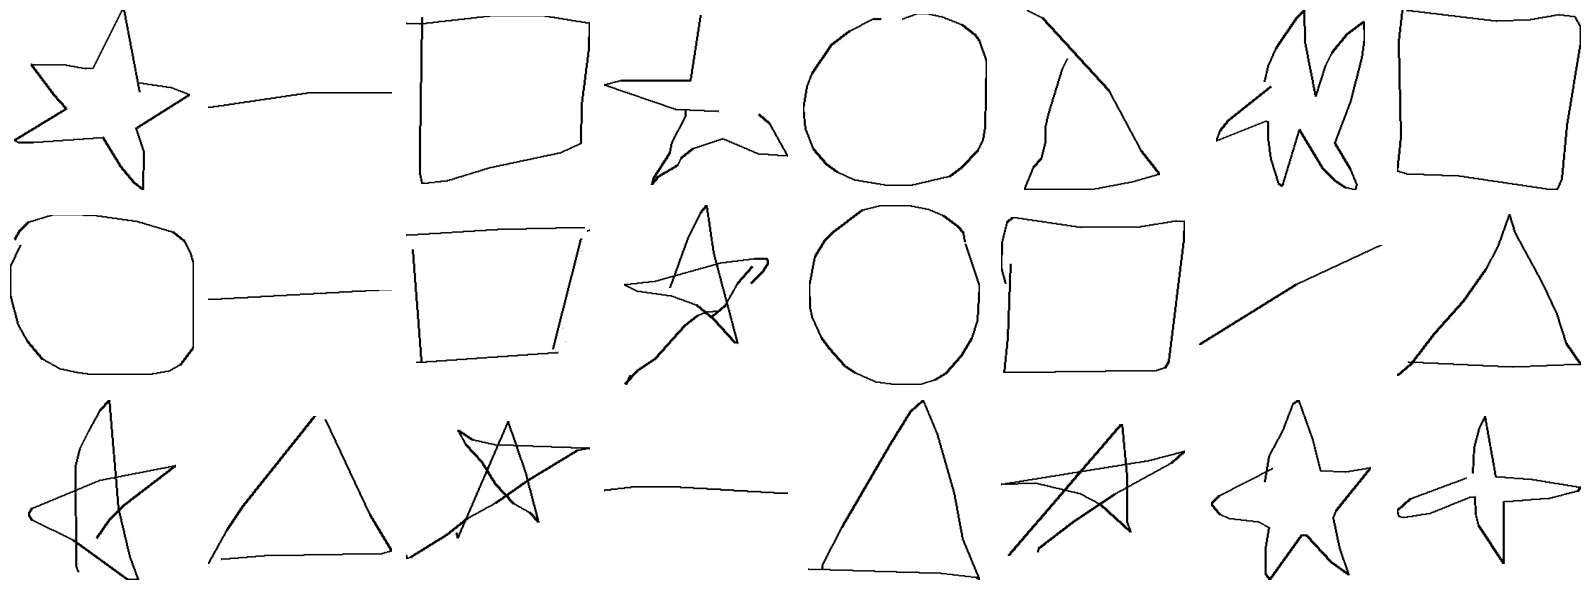

In [10]:
# Selects multiple random shapes/drawings and displays them all
display_multiple_drawings(dimensions=(3, 8))

## Data Augmentation
While flipping through the dataset, one that becomes apparent is that everyone has the same idea when drawing triangles: the base is parallel to the bottom. I looked through 150+ drawings before I found a triangle drawing facing a different direction, and it'd probably take me even longer to find the next one. This is not a good pattern because if the model is only trained on triangles pointing upwards, then it won't be able to tell that a drawing is triangle simply because it's rotated 90°.

This issue isn't difficult to address, all it takes is **data augmentation**. Very simply, we need to generate a few rotations for each drawing and add them to the dataset. This way, the neural network is exposed to a variation of orientations of each shape. This ensures it can easily identify a triangle even if it's "upside down".

Likely not every shape will need to be rotated, or at least not rotated as many times as some other shapes will need. For example, a triangle rotated either 45° or 90°, however many times, looks quite different. On the other hand a square rotated 90° looks the same but rotated 45° looks very different; this requires different rotations from each shape. We're going to limit the smallest rotation to an increment of 45°, any more would be unnecessary and just pollute the dataset. Let's not forget that neural networks are still pretty smart, they can figure it out 🧠😎.

What we're really doing is making sure each shape covers the a full variety. **A term I came up with to describe this is "image space"**. The triangles all (almost) only point upwards, meaning it's clearly missing lots of variation to cover the entire image space. Another thing is that drawings obviously don't look the exact same every time, just look at the drawings displayed above. From one triangle to the next, even in the same orientation, there is a significant amount of variation in the angles, where the lines meet, etc. That variation in drawing provides the core diversity that makes each drawing different. The goal of the rotation is to supplement only the missing variation. The rotations combined with the natural fluctuation of drawing results in a dataset with great dataset, hopefully leading to good training results..

To decide how many augmentations each shape will need, we're going to observe each shape rotated at 45° increments and see what we can deduce from it.

In [11]:
# Shape/image rotation

def rotate_point(x: int, y: int, angle: int) -> (int, int):
    """ Rotate a single point (coord) around the origin by a given angle in degrees. """
    rad_angle = radians(angle)
    x_rot = cos(rad_angle) * x - sin(rad_angle) * y
    y_rot = sin(rad_angle) * x + cos(rad_angle) * y
    return x_rot, y_rot

def rotate_strokes(strokes: list, angle: int) -> list:
    """ Rotate a series of strokes by a given angle in degrees and returns the rotated strokes. """

    if angle == 0:
        return strokes

    rotated_strokes = []

    for stroke in strokes:
        x_coords, y_coords = stroke
        new_x_coords, new_y_coords = [], []

        for x, y in zip(x_coords, y_coords):
            new_x, new_y = rotate_point(x, y, angle)
            new_x_coords.append(new_x)
            new_y_coords.append(new_y)

        rotated_strokes.append([new_x_coords, new_y_coords])

    return rotated_strokes

def demo_shape_rotations(axs, shape_drawing: list):
    """ Displays given shape drawing on axs plot in rotations of 45°. """
    # First displays right angle views, then diagonal views
    for i, angle in enumerate(list(range(0, 360, 90)) + list(range(45, 405, 90))):
        rotated_strokes = rotate_strokes(shape_drawing, angle)
        image = convert_strokes_to_image(rotated_strokes)
        axs[i].imshow(image)
        axs[i].set_title(f'{angle}°')
        axs[i].axis('off')


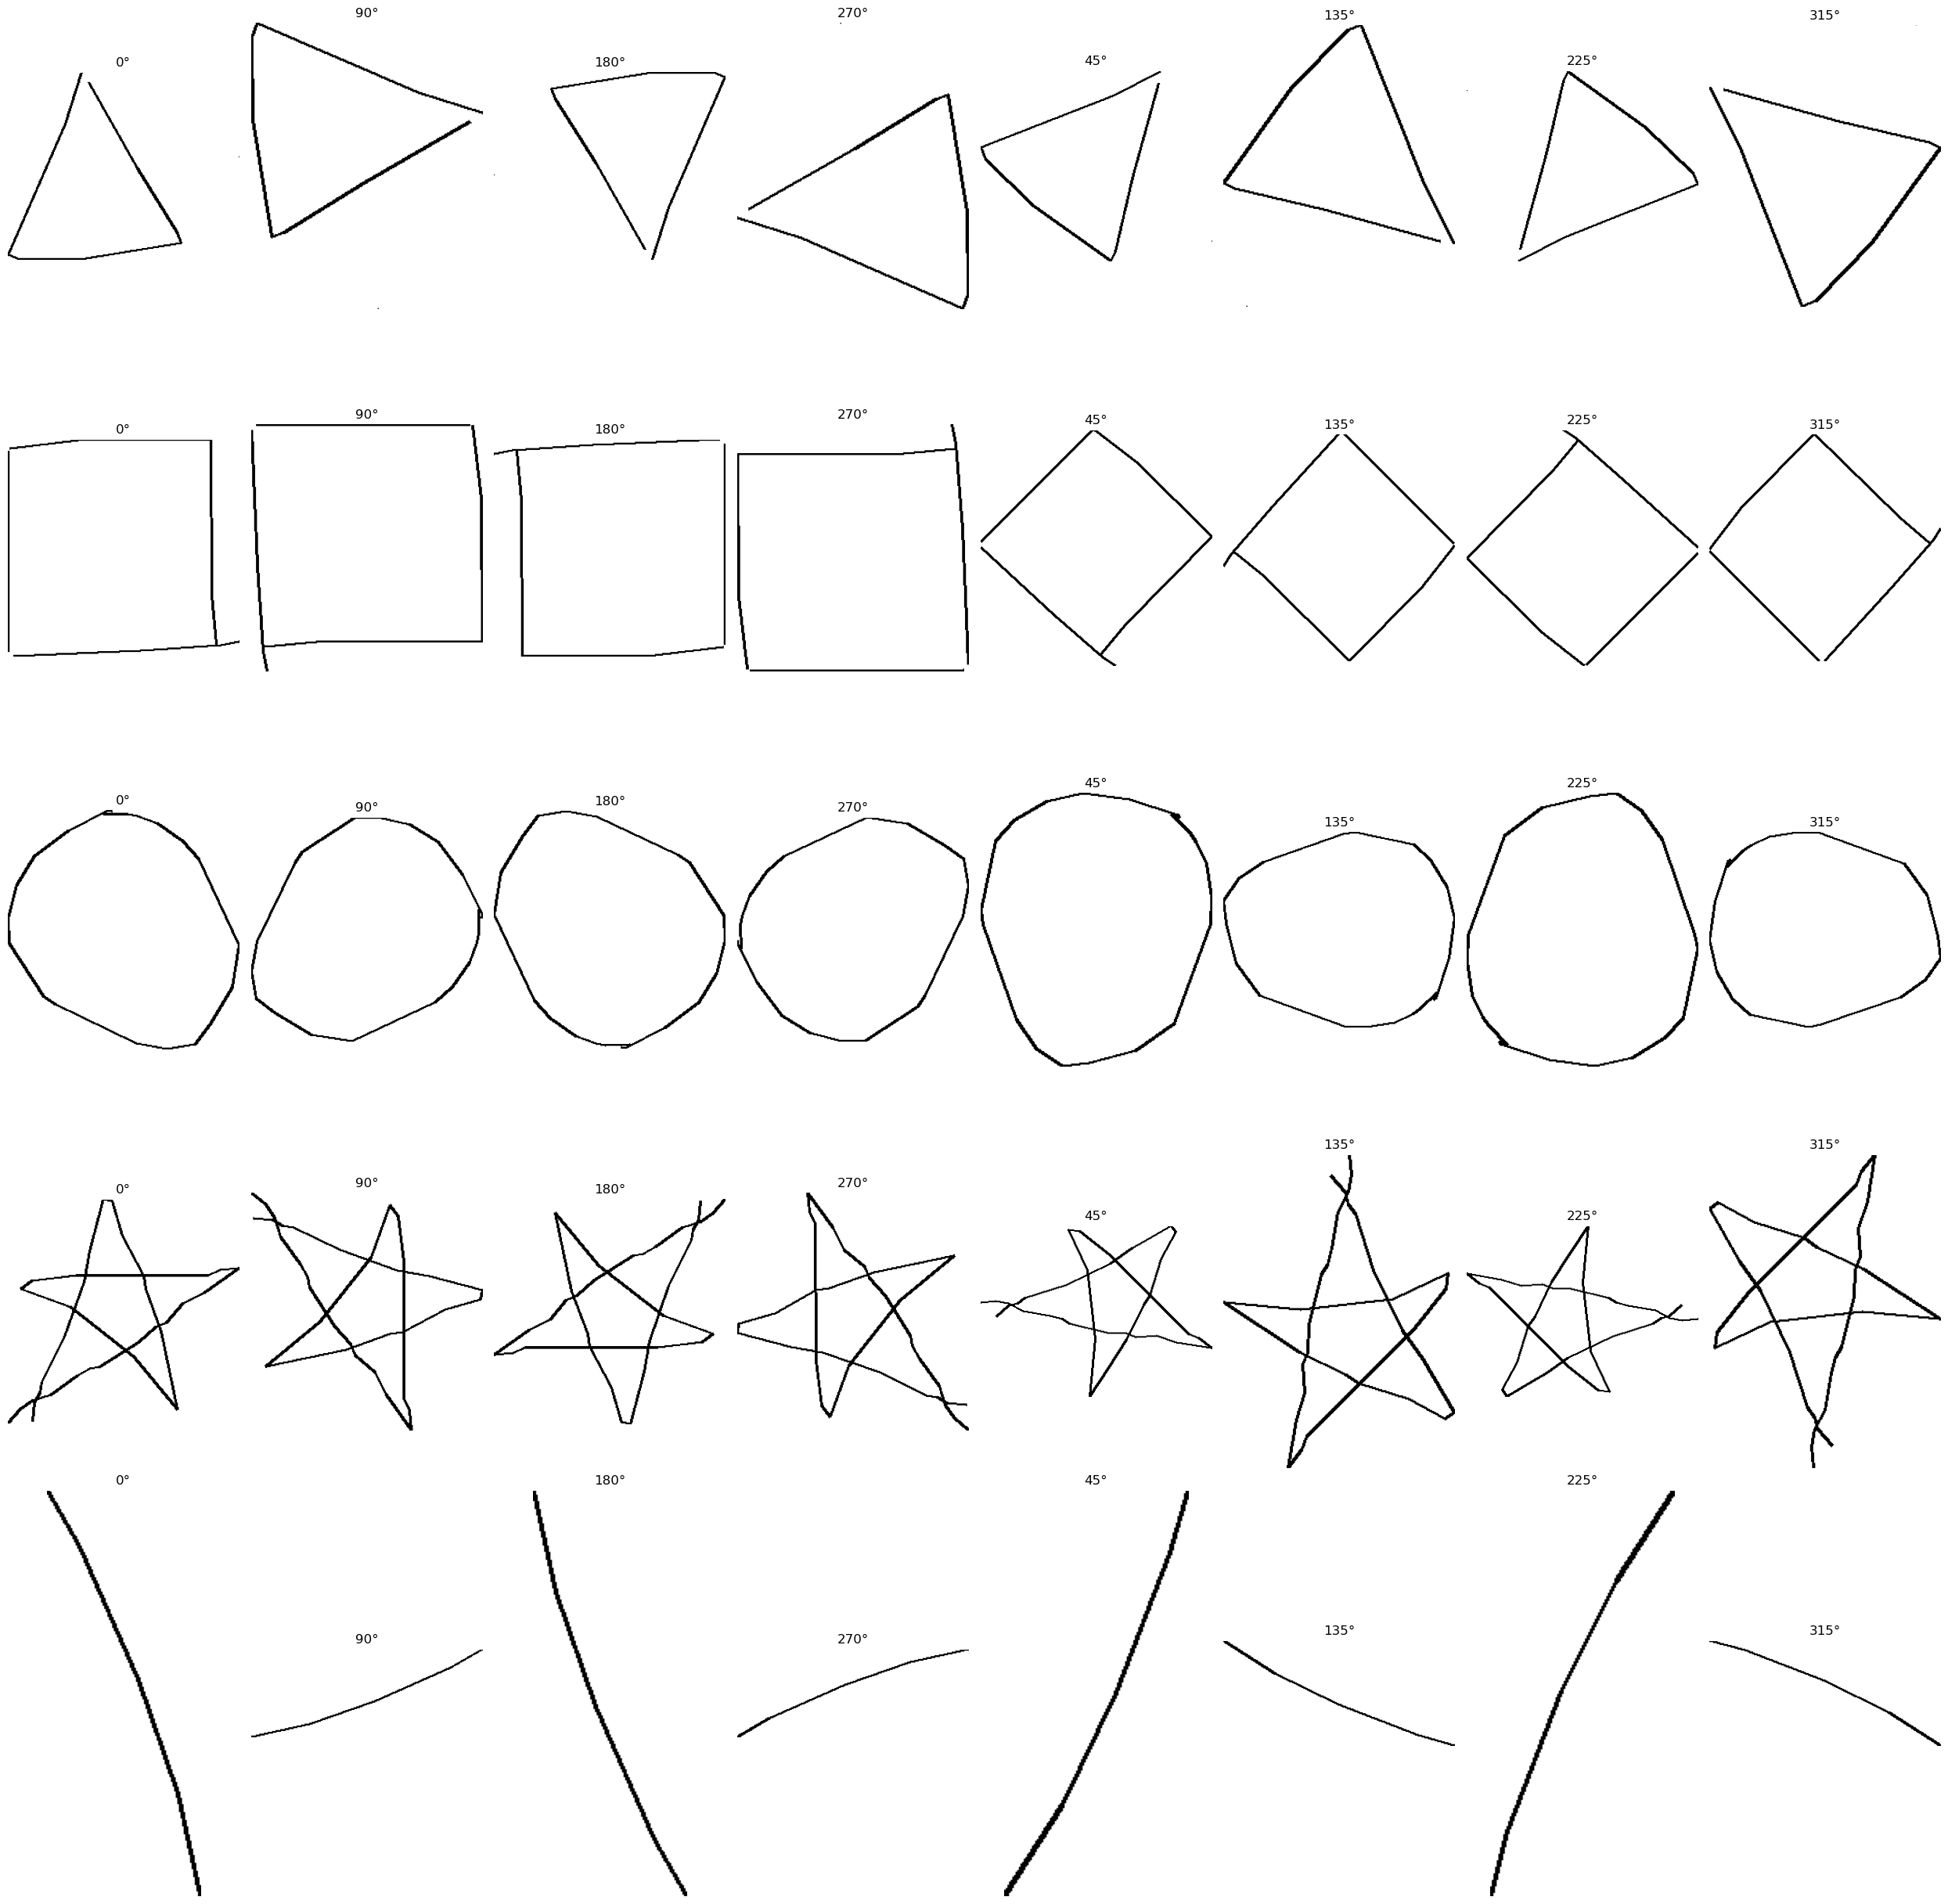

In [12]:
# Display rotation demo of every shape for analysis

# Main display code
fig = plt.figure(figsize=(25, 25))

# Create the grid for the 5 shape, each shape occupies a row
gs = fig.add_gridspec(5, 8)  # 5 rows, 8 columns

for i, (shape_id, drawing) in enumerate(key_drawings):
    axs = [fig.add_subplot(gs[i, j]) for j in range(8)]
    demo_shape_rotations(axs, drawing)

plt.tight_layout()
plt.show()

## Rotation (data augmentation cont.)
Looking at the drawings above, we can extrapolate many interesting details. Remember that we're **trying to address the problem of lack of variation**.

**To combat this problem,** we very simply need to fill this absence with drawings in different orientations. The thing is, not every shape has this problem. Take the star for example. When rotated it provides some variation, but if you looked at the rest of the star dataset you'd realize that that variation already exists due to natural fluctuations that come from human drawing; we can't draw perfectly like robots. In the star's case, we wouldn't need to generate any rotated drawings.

Let's look at one more shape, the square. The square looks the same in the right angle/upright orientations, however when it comes to the diagonals (45° orientations), it clearly looks different. More precisely, the diagonals look different relative only to the upright squares, but look the same compared to other diagonals. So for the square, we would only need to rotate each drawing 45° once, maybe a smaller angle as well.

Below are the rotations/copies each shape requires to have complete variation (does not include the original orientation).

| Shape    | Rotations          |
|----------|--------------------|
| triangle | +7: full range 45° |
| square   | +3: 30°, 45°, 60°  |
| circle   | +0: does not need  |
| star     | +0: does not need  |
| line     | +7: full range 45° |

- **Triangle** benefits from rotating all the way around, so we're going to include the full range in increments of 45°.
- **Square** on the other hand simply needs to be angled once (45°) to include diagonals. We're also going to include 30° and 60° (angled once as well) because I found that including smaller increments for the square provides even better variety.
- **Circle** will not be getting any rotations because its dataset has variation, so rotating it does not make any difference.
- **Star** will not be getting any rotations either for the same reason.
- **Line** has decent variation, but there's definitely a bit more horizontal lines than any other orientation. Due to this, it's just better to rotate it, so we're going rotate it the full range in increments of 45° so that all orientations are balanced.

In [13]:
# Rotations
shape_rotations = {
    'triangle': list(range(45, 360, 45)),  # 45° -> 360° in increments of 45°
    'line': list(range(45, 360, 45)),  # 45° -> 360° in increments of 45°
    'square': [30, 45, 60],  # angles 30°, 45°, 60°
}

## Balancing Augmented Data
Earlier, we split our dataset into the training, cross validation, and testing sets. We'll now augment our data, but adjusting different amounts for each class. This is going to not only produce even more data, but skew the previously balanced class distribution because each class will be augmented different amounts. We're going to use **undersampling** to address this, which is to randomly sample data from the bigger classes until they're as small as the smallest class. For example if the smallest class has 1,000 rows and another class has 6,000 after augmentation, we're going to randomly sample 1,000 from the bigger class and only use that.

### Augmented Data Usage
Usually data augmentation consists of "unnatural" augmentations because they help **improve model robustness**, even if they don't reflect typical real-world conditions. The rationale is to **expose the model to a wide variety of conditions**, so it learns to focus on essential features and generalizes better. For example, randomly changing brightness, contrast, saturation, and hue might produce colors that are never seen in the real world, but make the model less sensitive to specific color conditions; allowing it to generalize better. But because these are unnatural scenarios, they are only applied to the training data to improve model robustness/generalization, and testing data is left clean because you're not gonna see a bright green dog in the real world.

BUT in our specific case, we performed augmentation to **better mimic real world conditions**. The best reflection of this idea is our triangle dataset. I noticed that nearly all the triangles were drawn with the base parallel to the bottom. But in the real world, seeing a rotated triangle is not unnatural at all, so we would actually want to include it in the test set as well. So with this logic, both our training and testing sets will include the augmented and undersampled data above, which is an even mix of unaugmented and augmented data.

In [14]:
# Data augmentation (rotation) and undersampling  functions

def group_dataset_by_class(X_data: list[list], y_data: list[str]) -> dict:
    """ Given a dataset and its corresponding labels,
        groups it by class and returns the grouped sets. """
    class_data_dict = defaultdict(list)
    for drawing, label in zip(X_data, y_data):
        class_data_dict[label].append(drawing)

    return class_data_dict

def combine_class_data(class_grouped_data: dict, shuffle_return: bool = True) -> tuple[list]:
    """ Given a dataset grouped by class, combines it back together
        and returns the dataset and its corresponding labels. """

    # Original lists are not modified, creates new lists instead
    X_combined, y_combined = [], []

    for label, class_data in class_grouped_data.items():
        X_combined.extend(class_data)
        y_combined.extend([label]*len(class_data))

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle combined data because it's ordered by class
        X_combined, y_combined = shuffle(X_combined, y_combined, random_state=RAND_STATE_VAL)

    return X_combined, y_combined

def rotate_strokes_class_set(X_data: list[list], rotation_angles: list[int], shuffle_return: bool = True) -> list[list]:
    """ Given a dataset of a single class, returns an augmented dataset
        where each stroke sequence is rotated by the specified angles. """

    # Original list is not modified, creates new list instead
    X_augmented = deepcopy(X_data)

    # Rotate every stroke sequence by every angle, and appends the rotated stroke sequences
    for stroke_sequence in X_data:
        for angle in rotation_angles:
            rotated_stroke_sequence = rotate_strokes(stroke_sequence, angle)
            X_augmented.append(rotated_stroke_sequence)

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle augmented data to mix angles together, and to mix with original data
        X_augmented = shuffle(X_augmented, random_state=RAND_STATE_VAL)

    return X_augmented

def undersample_dataset(X_data: list[list], y_data: list[str], target_class_size: int, shuffle_return: bool = True) -> tuple[list]:
    """ Given a dataset and their respective labels, returns a dataset
        undersampled by class down to the given target class size. """

    # Original lists are not modified, creates new lists instead
    X_undersampled, y_undersampled = [], []

    # Group the data by class
    class_grouped_data = group_dataset_by_class(X_data, y_data)

    # Undersample each class
    for label, class_data in class_grouped_data.items():
        # Undersample ONLY if class is larger than target size
        if len(class_data) > target_class_size:
            class_data = random.sample(class_data, target_class_size)
        # Append to new undersampled dataset
        for drawing in class_data:
            X_undersampled.append(drawing)
            y_undersampled.append(label)

    # Optional shuffle
    if shuffle_return is True:
        # Shuffle undersampled data because data is ordered by class
        X_undersampled, y_undersampled = shuffle(X_undersampled, y_undersampled, random_state=RAND_STATE_VAL)

    return X_undersampled, y_undersampled

def undersample_class_set(X_data: list[list], target_class_size: int) -> list[list]:
    """ Given a dataset of a single class, returns a dataset
        undersampled down to the given target class size. """

    # Can not resize dataset if target class size is not smaller than it
    if target_class_size >= len(X_data):
        raise ValueError('Given target class size must be smaller than dataset.')

    # Sample target size from given dataset (does not modify original list)
    undersampled_data = random.sample(X_data, target_class_size)

    return undersampled_data

In [15]:
# Perform data augmentations
num_of_classes = len(classes)
train_class_size = len(X_train) // num_of_classes
valid_class_size = len(X_valid) // num_of_classes
test_class_size = len(X_test) // num_of_classes

# === Training Set ===
train_set_grouped_classes = group_dataset_by_class(X_train, y_train)

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    augmented_data = rotate_strokes_class_set(train_set_grouped_classes[shape], angles)
    train_set_grouped_classes[shape] = undersample_class_set(augmented_data, train_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_train_augmented, y_train_augmented = combine_class_data(train_set_grouped_classes)
del train_set_grouped_classes  # delete, same as augmented, just grouped by class

# === Validation Set ===
valid_set_grouped_classes = group_dataset_by_class(X_valid, y_valid)

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    augmented_data = rotate_strokes_class_set(valid_set_grouped_classes[shape], angles)
    valid_set_grouped_classes[shape] = undersample_class_set(augmented_data, valid_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_valid_augmented, y_valid_augmented = combine_class_data(valid_set_grouped_classes)
del valid_set_grouped_classes  # delete, same as augmented, just grouped by class

# === Testing Set ===
test_set_grouped_classes = group_dataset_by_class(X_test, y_test)

# Iterate through each shape's angles and perform augmentation
for shape, angles in shape_rotations.items():
    # Augment current shape and undersample it to reduce size
    augmented_data = rotate_strokes_class_set(test_set_grouped_classes[shape], angles)
    test_set_grouped_classes[shape] = undersample_class_set(augmented_data, test_class_size)

# Combine all classes back together after they've been separately augmented and undersampled
X_test_augmented, y_test_augmented = combine_class_data(test_set_grouped_classes)
del test_set_grouped_classes  # delete, same as augmented, just grouped by class

# === Dataset Versions we have now ===
"""
Original data:
  - X_train
  - X_valid
  - X_test

Augmented & undersampled data, final clean result:
  - X_train_augmented
  - X_valid_augmented
  - X_test_augmented
  
Y Labels Set: always has the same name as X sets,
with the only difference being that it starts with `y_` instead of `X_`
""";
# ====================================

## Image Resizing
We're very close to finishing up with preprocessing and nearing training 😳. This next very important step is to resize the images to a much smaller dimension. This is crucial to expedite computational processing, reduce memory footprint, and especially to ensure consistent input shape for our machine learning model, without sacrificing significant information from the original data.

Some common sizes I've found for input images for deep learning are 224x224 and 256x256, but the more basic your images are, the smaller you can make your images (without sacrificing detail/information). I found that 48x48 is a good size that's quite small but still displays very clear shapes; it's just a bit bigger than MNIST's handwritten digits image size.

Below is a modified version of the `convert_strokes_to_image` function that first resizes the drawing strokes to the given target size before drawing it. This new function, `convert_strokes_to_resized_image` is very powerful. It first performs many calculations to figure out how to resize the image and center it, then draws it on a bigger canvas first before resizing down to give the blurred antialias effect. Although we won't be feeding image files directly into our model, this intermediary image format between the stroke sequence data and the input to the model is crucial because it's placing the drawing into a frame/canvas; effectively deciding on a position and size relative to its borders.

In [16]:
def convert_strokes_to_resized_image(data, target_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> Image.Image:
    """ Converts stroke data to an image using PIL at given dimensions.
    We draw the image on a larger canvas first then resize down to give the anti-aliasing effect.
    """

    # Compute the bounds of the stroke data to determine the size of the image.
    min_x = min([min(stroke[0]) for stroke in data])
    max_x = max([max(stroke[0]) for stroke in data])
    min_y = min([min(stroke[1]) for stroke in data])
    max_y = max([max(stroke[1]) for stroke in data])

    original_width = int(max_x - min_x + 1)
    original_height = int(max_y - min_y + 1)

    # Calculate the scaling factors for x and y axes
    scale_factor = min((target_size[0] * antialias_factor) / original_width, (target_size[1] * antialias_factor) / original_height)

    # Initialize a blank white image of a larger resolution for antialiasing
    intermediate_image = Image.new("RGB", (target_size[0] * antialias_factor, target_size[1] * antialias_factor), "white")
    draw = ImageDraw.Draw(intermediate_image)

    # Calculate offsets to center the drawing in the intermediate canvas
    centered_width = original_width * scale_factor
    centered_height = original_height * scale_factor
    offset_x = (target_size[0] * antialias_factor - centered_width) / 2
    offset_y = (target_size[1] * antialias_factor - centered_height) / 2

    for stroke in data:
        for i in range(len(stroke[0]) - 1):
            x0, y0 = (stroke[0][i] - min_x) * scale_factor + offset_x, (stroke[1][i] - min_y) * scale_factor + offset_y
            x1, y1 = (stroke[0][i + 1] - min_x) * scale_factor + offset_x, (stroke[1][i + 1] - min_y) * scale_factor + offset_y
            draw.line([(x0, y0), (x1, y1)], fill="black", width=int(stroke_width * sqrt(antialias_factor)))

    # Resize the image down to target size to achieve the antialiasing effect
    final_image = intermediate_image.resize(target_size, Image.ANTIALIAS)

    return final_image


## Image to Tensors
Our images have a dimension of 48x48, but our model can't normally accept more than 1 dimension as input. A solution to this is a Tensor. **TensorFlow has a datatype called Tensors that is the most efficient type for models** and allows the model to accept data of whatever dimension without resizing. 

In [17]:
# === Image and Tensor Dataset Conversion ===
def convert_strokes_dataset_to_images(X_data: list[list], image_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> list[Image.Image]:
    """ Given a dataset of stroke sequences, resizes and draws each one
        and returns it as a list of PIL images. """
    return [convert_strokes_to_resized_image(drawing, image_size, stroke_width, antialias_factor) for drawing in X_data]

# Get reference to Tensor type for typehinting
Tensor = type(tf.image.rgb_to_grayscale(convert_strokes_to_image(X_train[0])))
# * to display Tensor, convert to numpy() first then show with plt

def image_to_tensor(image: Image.Image) -> Tensor:
    """ Converts given PIL image to a Tensor with one color channel. """
    return tf.image.rgb_to_grayscale(image)

def convert_images_dataset_to_tensors(X_data: list[Image.Image]) -> list[Tensor]:
    """ Given a dataset of PIL images, converts and returns it as Tensors. """
    return [image_to_tensor(image) for image in X_data]

def convert_strokes_dataset_to_tensors(X_data: list[list], image_size: tuple[int, int], stroke_width=5, antialias_factor=4) -> list[Tensor]:
    """ Given a dataset of stroke sequences, resizes and draws each one as PIL images,
        then converts each to a Tensor and returns the final Tensor dataset. """
    return [image_to_tensor(convert_strokes_to_resized_image(drawing, image_size, stroke_width, antialias_factor)) for drawing in X_data]


In [18]:
# Convert dataset into Tensors

DIM = 48  # Image dimension (one side)

X_train_tensors = convert_strokes_dataset_to_tensors(X_train_augmented, (DIM, DIM))
X_valid_tensors = convert_strokes_dataset_to_tensors(X_valid_augmented, (DIM, DIM))
X_test_tensors = convert_strokes_dataset_to_tensors(X_test_augmented, (DIM, DIM))

# === New Dataset Versions ===
"""
Tensor data:
  - X_train_tensors
  - X_valid_tensors
  - X_test_tensors
""";
# ==============================

print(X_train_tensors[0].shape)

(48, 48, 1)


Notice now that the shape of one tensor is (48, 48, 1). The third value is the number of color channels. Since we're using grayscale images, the channel is just 1.

## Data Normalization
We're at the last step of preprocessing! Now that we have our data as images/tensors with pixel values, we can normalize them. At the moment, if you were to look at the range of the pixel values of any image, it would range from 0 to 255. But in machine learning, especially for neural networks, keeping the range of your data small helps the model converge faster and reach a better local minimum. To do this we have to perform normalization.

This is done by taking every pixel and squeezing it into a range of 0 to 1. To squeeze it, we simply divide the pixel's value by 255, effectively scaling it to a range of 0 to 1. This normalization step is applied to all 3 sets: training, validation, and testing.

In [19]:
def normalize_tensor_dataset(X_data: list[Tensor], max_value: int = 255) -> list[Tensor]:
    """ Given a dataset of Tensors, returns the normalized dataset. """
    return [(tf.cast(tensor, tf.float32) / float(max_value)) for tensor in X_data]

In [20]:
# Normalize each set
X_train_tensors = normalize_tensor_dataset(X_train_tensors)
X_valid_tensors = normalize_tensor_dataset(X_valid_tensors)
X_test_tensors = normalize_tensor_dataset(X_test_tensors)

Now that our X data has been completely preprocessed, we can stack the tensors. Currently, our drawings data is stored as a list of tensors, but we can combine this into a Tensor stack which is a much way to store the dataset.

In [21]:
# Convert data to a single Tensor
X_train_tensor = tf.stack(X_train_tensors, axis=0)
X_valid_tensor = tf.stack(X_valid_tensors, axis=0)
X_test_tensor = tf.stack(X_test_tensors, axis=0)

""" These tensors have the shape (m_rows, height, width, channels),
which is the format expected when training models in TensorFlow. """;

As for our labels, there's just one processing step we have to apply to them. The labels have been stored as strings the entire time, but our model can't process strings. Instead we have to encode the shape names as integers, where each shape name corresponds to an integer. After we train our model and make an inference with it, we can convert the output integer into its corresponding string name.

In [22]:
# Encode the string classes (shape names) into integers
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_augmented)
y_valid_encoded = encoder.transform(y_valid_augmented)
y_test_encoded = encoder.transform(y_test_augmented)

encoder_mappings = [None] * len(encoder.classes_)  # index: label

for original_label, encoded_label in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"Original Label: {original_label}, Encoded Label: {encoded_label}")
    encoder_mappings[encoded_label] = original_label

print(encoder_mappings)

Original Label: circle, Encoded Label: 0
Original Label: line, Encoded Label: 1
Original Label: square, Encoded Label: 2
Original Label: star, Encoded Label: 3
Original Label: triangle, Encoded Label: 4
['circle', 'line', 'square', 'star', 'triangle']


# Training Time 🏋
At last, it's time to train! But not quite. Before we can actually start training the model, we have to define the model itself. The model needs a suitable architecture, optimizer & loss function, set initial hyperparameters, etc.

## Model Architecture
Arguably the most important part is model architecture, because that's literally the model itself. Because our task, identifying drawings of basic shapes, is a **computer vision task**, we're going to employ the use of a **Convolutional Neural Network (CNN)**. A CNN is a is a type of artificial intelligence model designed for computer vision (CV). Through layers that scan small sections of an image, it can automatically and adaptively learn spatial hierarchies of features. This means a CNN can start by detecting edges, then shapes by combining edges, and even more complex structures as it goes deeper, making it highly effective for tasks like object recognition in photos.

In [23]:
# Model and Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Optimizer and Loss function
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Model Evaluation & Checkpointing
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

After lots of hyper parameter tuning (not shown) and training, this is the model architecture we settled on. It features 3 convolutional layers for feature extraction, and then 2 large dense layers with dropout for classification. We also regularized it with L2 regularization to reduce overfitting, and finally compiled it with the Adam optimizer.

In [33]:
image_dimension = (48, 48, 1)  # 48 x 48 images, w/ 1 color channel (grayscale)
lambda_val = 0.0002  # Lambda value for regularization

model = Sequential([
    # == Input ==
    Input(shape=image_dimension),  # Specifies shape of inputs (images)

    # == Feature Extraction (initial) ==
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(lambda_val)),  # Conv. layer learns the significant features in the input
    MaxPooling2D(pool_size=(2, 2)),  # Reduces dimensionality of the input to alleviate the computational load

    # == Feature Extraction (deeper) ==
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(lambda_val)),  # 2nd conv. learns more complex patterns
    MaxPooling2D(pool_size=(2, 2)),  # Also reduces overfitting because it's reducing dimensions

    # == Feature Extraction (EVEN deeper) ==
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(lambda_val)),  # Added another conv. to introduce more complexity
    MaxPooling2D(pool_size=(2, 2)),

    # == Classification ==
    Flatten(),  # Flattens 2D outputs from previous layers to prepare data for fully connected layers

    Dense(256, activation='relu', kernel_regularizer=l2(lambda_val)),     # Increased neurons in first layer
    Dropout(0.5),                      # Adjusted dropout for added complexity
    Dense(128, activation='relu', kernel_regularizer=l2(lambda_val)),     # Add another dense layer for more complexity
    Dropout(0.5),                      # Dropout for the added dense layer

    # == Output ==
    Dense(5, activation='linear')  # Softmax, but we do linear first then softmax after for numerical accuracy
])

model.summary()

# Compile Model
model.compile(optimizer=Adam(0.0005), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

## Training !!
Now that we have a model set up, we're actually ready for training!!! We're going to log our progress so that we could display them with TensorFlow graphs. We also set up a checkpoint callback, which monitors the validation loss and continuously saves the parameters every time the validation loss is at its lowest. This allows us to keep hold of the best performing parameters before the loss starts increasing. Sometimes we reach the best validation loss early on, so to prevent unnecessary training we also added early stopping.

In [34]:
# === Training ===
tuning_logs = 'CompareHyper/'

# Check last model tuning iteration and increment it
all_dirs = [d for d in os.listdir(tuning_logs) if os.path.isdir(os.path.join(tuning_logs, d))]
all_dirs = list(filter(lambda x: x.isnumeric(), all_dirs))
all_dirs = list(map(lambda x: int(x), all_dirs))
model_iteration = max(all_dirs, default=0) + 1
model_stats_dir = tuning_logs + str(model_iteration) + '/'

# Tensorboard
log_dir = model_stats_dir + 'logs' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Directory to save tensorboard logs
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=model_stats_dir+'training_checkpoint.h5',
    monitor='val_loss',     # Monitor the validation loss
    verbose=1,              # Log a message when saving
    save_best_only=True,    # Only save the best model
    mode='min'              # The best model is the one with minimal validation loss
)

# == TRAIN !!! ==
history = model.fit(X_train_tensor, y_train_encoded,
                    epochs=20,
                    batch_size=32,  # 64 next
                    validation_data=(X_valid_tensor, y_valid_encoded),
                    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping],
                    verbose=1)

Epoch 1/20


1873/1875 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.9049
Epoch 1: val_loss improved from inf to 0.17158, saving model to CompareHyper/15/training_checkpoint.h5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.3593 - accuracy: 0.9049 - val_loss: 0.1716 - val_accuracy: 0.9707
Epoch 2/20
1872/1875 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9703
Epoch 2: val_loss improved from 0.17158 to 0.13808, saving model to CompareHyper/15/training_checkpoint.h5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1788 - accuracy: 0.9703 - val_loss: 0.1381 - val_accuracy: 0.9800
Epoch 3/20
1871/1875 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9777
Epoch 3: val_loss improved from 0.13808 to 0.12051, saving model to CompareHyper/15/training_checkpoint.h5
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1478 - accuracy: 0.9777 - val_loss: 0.1205 - val_accuracy: 0.

In [35]:
def extract_metrics(history_data: dict):
    # Metrics for final epoch
    total_epoch_count = len(history.history['accuracy'])
    final_train_acc = history_data['accuracy'][-1]
    final_val_acc = history_data['val_accuracy'][-1]
    final_train_loss = history_data['loss'][-1]
    final_val_loss = history_data['val_loss'][-1]

    # Metrics for epoch with best validation loss (i.e., checkpoint)
    best_epoch_idx = np.argmin(history_data['val_loss'])
    checkpoint_train_acc = history_data['accuracy'][best_epoch_idx]
    checkpoint_val_acc = history_data['val_accuracy'][best_epoch_idx]
    checkpoint_train_loss = history_data['loss'][best_epoch_idx]
    checkpoint_val_loss = history_data['val_loss'][best_epoch_idx]

    # Display results
    print("=== BEST CHECKPOINT (Validation Loss) ===")
    print(f"Epoch: {best_epoch_idx + 1}")
    print(f"Train Acc.: {checkpoint_train_acc:.4f}")
    print(f"Valid. Acc.: {checkpoint_val_acc:.4f}")
    print(f"Train Loss: {checkpoint_train_loss:.4f}")
    print(f"Valid. Loss: {checkpoint_val_loss:.4f}")
    
    print("\n=== FINAL EPOCH ===")
    print(f"Epoch: {total_epoch_count}")
    print(f"Train Acc.: {final_train_acc:.4f}")
    print(f"Valid. Acc.: {final_val_acc:.4f}")
    print(f"Train Loss: {final_train_loss:.4f}")
    print(f"Valid. Loss: {final_val_loss:.4f}")

# Extract metrics, save history, and save final params
extract_metrics(history.history)

with open(model_stats_dir+'model_history.json', 'w+') as outfile:
    json.dump(history.history, outfile, indent=4)

model.save(model_stats_dir+'final_epoch_params.h5')

=== BEST CHECKPOINT (Validation Loss) ===
Epoch: 14
Train Acc.: 0.9869
Valid. Acc.: 0.9866
Train Loss: 0.0898
Valid. Loss: 0.0907

=== FINAL EPOCH ===
Epoch: 17
Train Acc.: 0.9877
Valid. Acc.: 0.9867
Train Loss: 0.0877
Valid. Loss: 0.0923


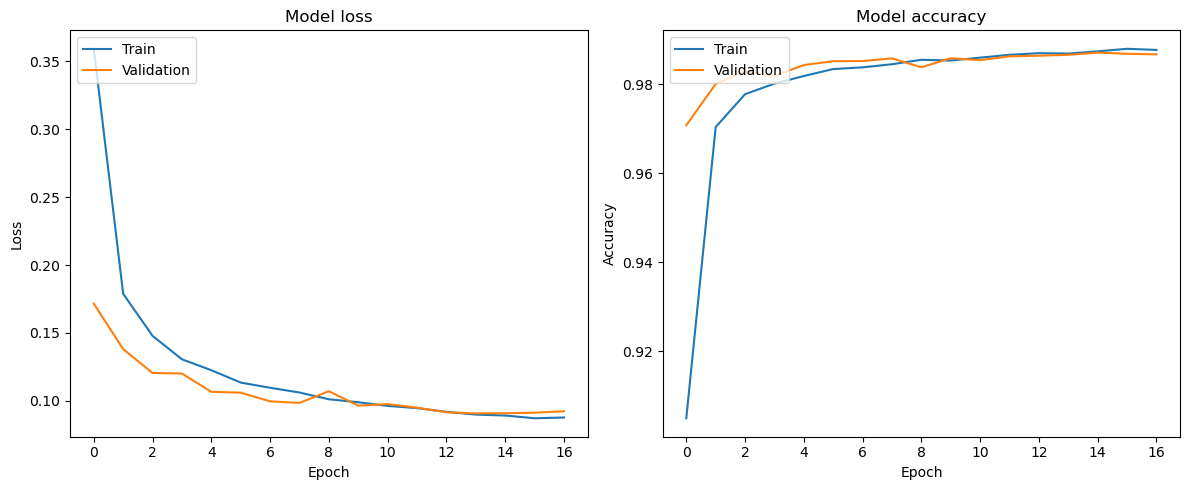

In [39]:
# Plots loss and accuracy for both training and loss

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots side by side

# Plot training & validation loss values on the first subplot
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy on the second subplot
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Evaluation and Trying it
Below is the final evaluation on the test set. We achieved a loss of 0.0941, and an accuracy of 0.986, which is a pretty good result. To try out the model, you can run the last cell to randomly pick a drawing from the test it and have the model run inference on it. I include the outputs of every class, so you can see how confident the model was, and what other shapes it might've considered.

In [37]:
# === Evaluations ===

loss, accuracy = model.evaluate(X_test_tensor, y_test_encoded)

# Evaluations of each class
y_pred = model.predict(X_test_tensor)
y_pred_classes = np.argmax(y_pred, axis=1)

print(f'Loss: {loss}, Accuracy: {accuracy}\n')
print(classification_report(y_test_encoded, y_pred_classes, target_names=encoder.classes_))

# Loss: 0.09414088726043701, Accuracy: 0.9857333302497864

938/938 [==============================] - 3s 3ms/step
Loss: 0.09414088726043701, Accuracy: 0.9857333302497864

              precision    recall  f1-score   support

      circle       0.99      0.99      0.99      6000
        line       0.98      0.99      0.98      6000
      square       0.99      0.99      0.99      6000
        star       0.99      0.98      0.98      6000
    triangle       0.98      0.98      0.98      6000

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



1/1 [==============================] - 0s 31ms/step

                        circle    line    square    star    triangle    
Confidence (percentage): 0.0      0.0      0.0      100.0    0.0      
Label: star, Prediction: star


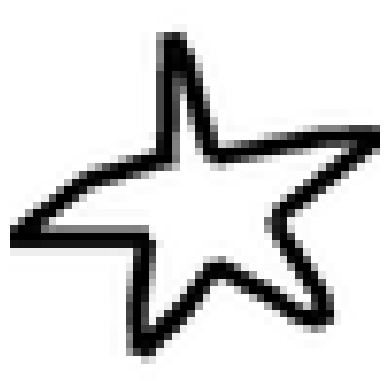

In [38]:
rand_i = random.randint(0, len(X_test_tensors)-1)
img_tensor, label = X_test_tensors[rand_i], y_test_augmented[rand_i]

tensor_input = tf.expand_dims(img_tensor, 0)  # Add batch size dimension

# Make prediction
pred_logits = model.predict(tensor_input)
prediction = tf.nn.softmax(pred_logits)
probabilities = prediction.numpy()[0]*100
highest_choice = np.argmax(prediction)
pred_class = encoder_mappings[highest_choice]
print()

# predictions
print('                        ', end='')
for index, elem in enumerate(encoder_mappings):
    print(elem, end='    ')
print()

print('Confidence (percentage):', end=' ')
for prob in probabilities:
    print(f'{prob:<8.1f}', end=' ')
    #             <8.3f}
print()

print(f'Label: {label}, Prediction: {pred_class}')

plt.imshow(img_tensor.numpy(), cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

# Conclusion and Reflections
In this notebook, we embarked on an image classification journey, aiming to classify drawings using a Convolutional Neural Network (CNN). Through rigorous experimentation, our model achieved a noteworthy accuracy of 98.6% on the test set. This success underscores the efficacy of the CNN model, especially with three convolutional layers. We also found L2 regularization and dropout layers to be particularly effective in mitigating overfitting.

However, the journey wasn't without challenges. The model had difficulty towards the end of fine tuning, despite having such a large complete dataset. To advance this work, I strongly believe that performing further data augmentation could improve model robustness and refine accuracy.

Thank you for following along this exploration of CNNs in image classification. Thank you for your time and patience in going through the entire notebook, I hope you find it interesting!